In [287]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler



In [362]:
# function to get data
def get_dataframe(path):
    if not path:
        return pd.DataFrame()
    df = pd.DataFrame()
    try:
        filename, file_extension = os.path.splitext(path)
        if file_extension == ".json":
            df = pd.read_json(path)
        elif file_extension == ".csv":
            df = pd.read_csv(path)

        return df
    except Exception as e:
        return pd.DataFrame()

In [363]:
train = get_dataframe("../data/train.csv")
test = get_dataframe("../data/test.csv")

In [364]:
train.shape, test.shape

((550068, 12), (233599, 11))

In [291]:
train.columns.difference(test.columns)

Index(['Purchase'], dtype='object')

In [292]:
train.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

In [293]:
test.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2             72344
Product_Category_3            162562
dtype: int64

In [294]:
def column_segregation(df):
    try:
        numerical_columns = df.select_dtypes(include = np.number).columns
        categorical_columns = df.select_dtypes(exclude = np.number).columns
        return numerical_columns, categorical_columns
    except Exception as e:
        return pd.DataFrame(), pd.DataFrame()
    

In [295]:
def fill_null(df, ignore_columns = []):
    
    try:        
        if type(ignore_columns) == str:
            ignore_columns = [ignore_columns]
        numerical_columns, categorical_columns = column_segregation(df)
        for column in numerical_columns:
            if column not in ignore_columns:
                df[column]=df[column].fillna(df[column].median())
        for column in categorical_columns:
            if column not in ignore_columns:
                df[column]=df[column].fillna(df[column].mode())
        return df
    except Exceptation as e:
        return pd.DataFrame()

In [296]:
fill_null(train, ignore_columns = ["Product_Category_2", "Product_Category_3"])
train.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

In [297]:
fill_null(test, ignore_columns = ["Product_Category_2", "Product_Category_3"])
test.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2             72344
Product_Category_3            162562
dtype: int64

In [298]:
train['Product_Category_2'] = train['Product_Category_2'].fillna(train['Product_Category_2'].median())
train['Product_Category_3'] = train['Product_Category_3'].fillna(0)
test['Product_Category_2'] = test['Product_Category_2'].fillna(test['Product_Category_2'].median())
test['Product_Category_3'] = test['Product_Category_3'].fillna(0)

In [299]:
train[["Product_Category_2","Product_Category_3"]] = train[["Product_Category_2","Product_Category_3"]].astype(int)
test[["Product_Category_2","Product_Category_3"]] = test[["Product_Category_2","Product_Category_3"]].astype(int)

In [300]:
def residence(df):
    df['Stay_In_Current_City_Years']= df['Stay_In_Current_City_Years'].map({'4+':4,'3':3,'2':2,'1':1,'0':0})
    return df

In [301]:
def city_category(df):
    df['City_Category'] = df['City_Category'].map({'A':1, 'B':2, 'C':3})
    return df

In [302]:
def gender(df):
    df['Gender'] = df['Gender'].map({'M':1, 'F':0})
    return df

In [303]:
def age_gap(df):
    df['Age'] = df["Age"].map({'18-25':1, '26-35':2, '36-45':3,'46-50':4,'51-55':5,'55+':6, '0-17':0})
    return df

In [304]:
def age_category(df):
    
    df['kids'] = df["Age"].map(lambda d:1 if d=='0-17' else 0)
    df['youth'] = df["Age"].map(lambda d:1 if d=='18-25' else 0)
    df['Adults'] = df["Age"].map(lambda d:1 if d=='26-35' else 0)
    df['midage'] = df["Age"].map(lambda d:1 if d=='36-45' else 0)
    df['oldage'] = df["Age"].map(lambda d:1 if d=='46-50' else 0)
    df['elderly'] = df["Age"].map(lambda d:1 if d=='51-55' else 0)
    df['senior'] = df["Age"].map(lambda d:1 if d=='55+' else 0)
    return df

In [305]:
train = residence(train)
test = residence(test)

train = city_category(train)
test = city_category(test)

train = gender(train)
test = gender(test)

train = age_category(train)
test = age_category(test)

train = age_gap(train)
test = age_gap(test)

In [306]:
train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,kids,youth,Adults,midage,oldage,elderly,senior
0,1000001,P00069042,0,0,10,1,2,0,3,9,0,8370,1,0,0,0,0,0,0
1,1000001,P00248942,0,0,10,1,2,0,1,6,14,15200,1,0,0,0,0,0,0
2,1000001,P00087842,0,0,10,1,2,0,12,9,0,1422,1,0,0,0,0,0,0
3,1000001,P00085442,0,0,10,1,2,0,12,14,0,1057,1,0,0,0,0,0,0
4,1000002,P00285442,1,6,16,3,4,0,8,9,0,7969,0,0,0,0,0,0,1


Text(0.5, 1.0, 'Correlation between features')

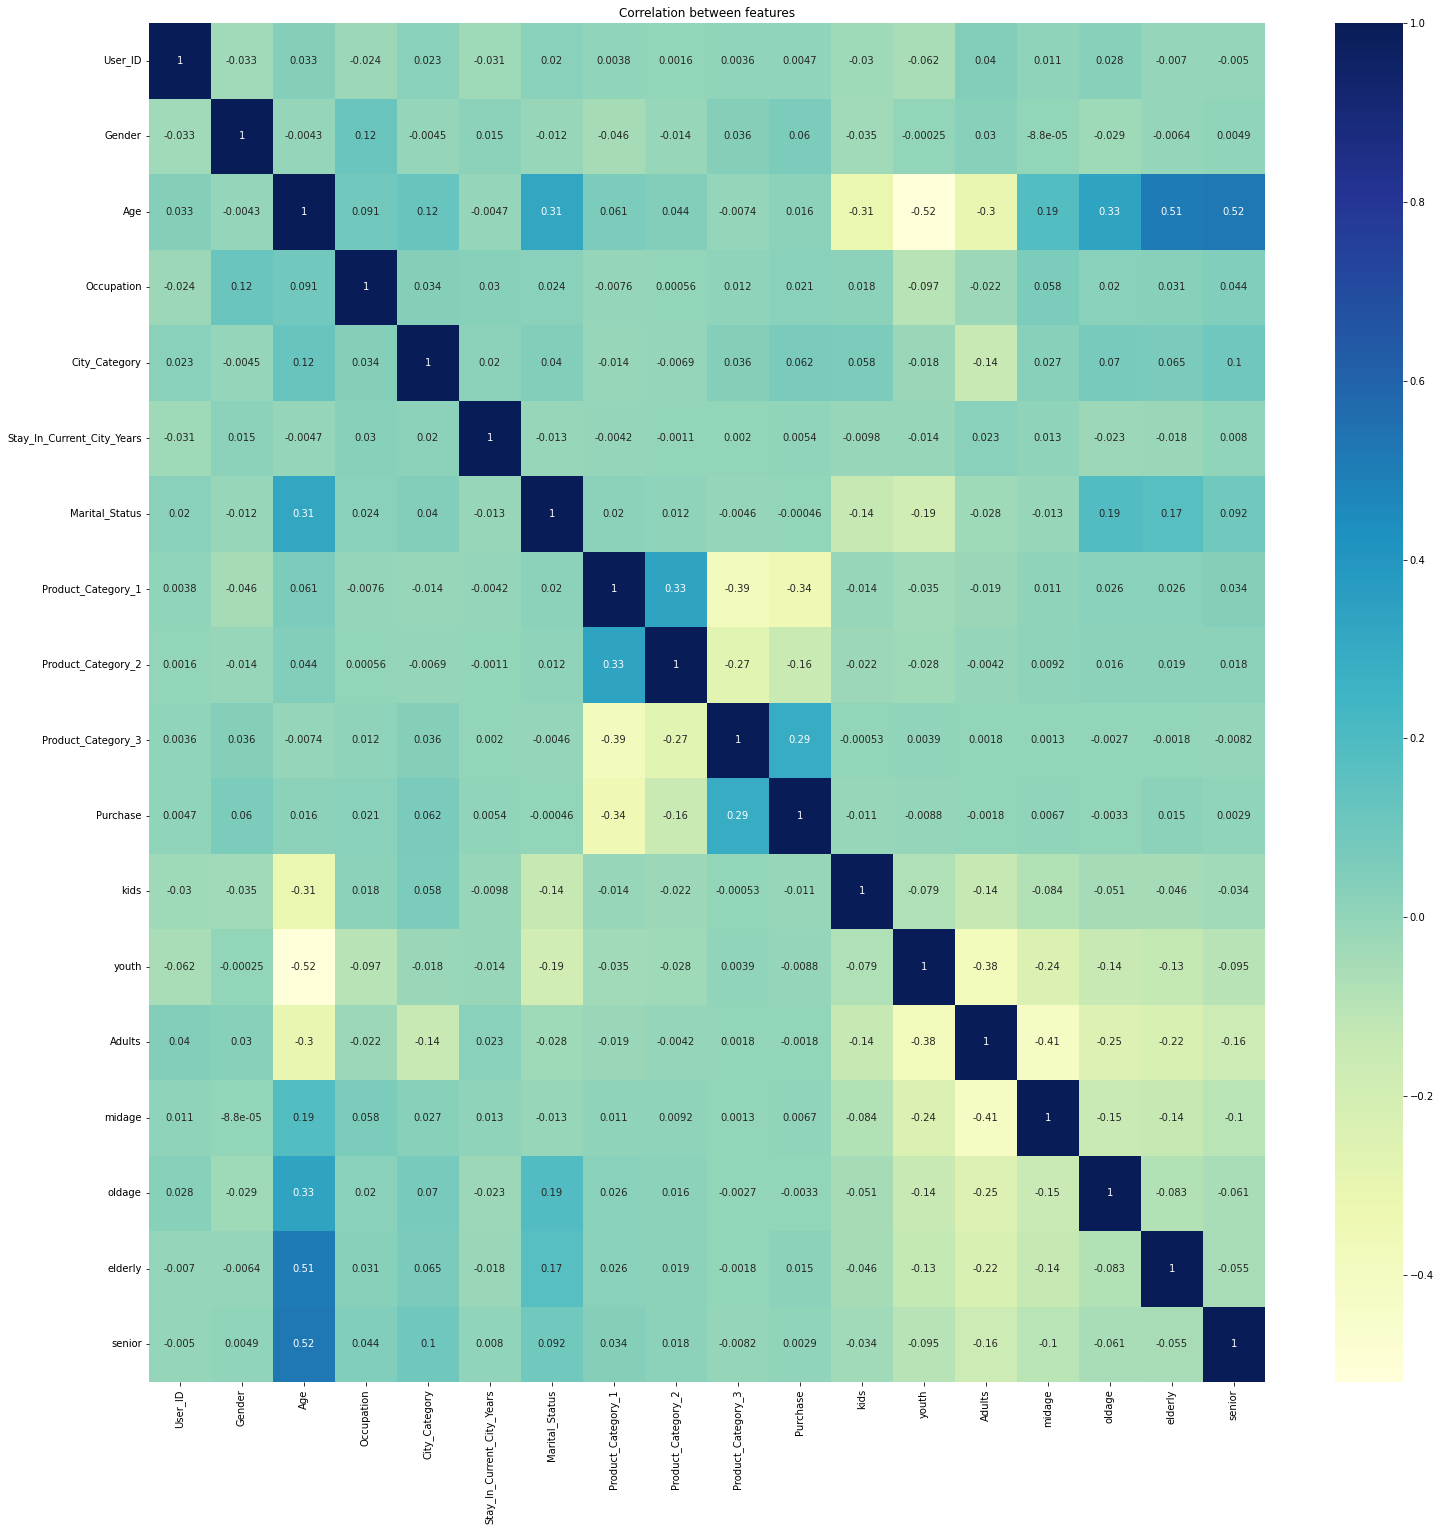

In [307]:
fig, ax = plt.subplots(figsize=(25,25))
corr_ = train.corr()
sns.heatmap(corr_, annot=True, cmap="YlGnBu").set_title("Correlation between features") 

<AxesSubplot:>

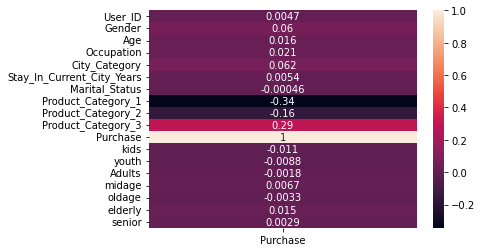

In [308]:
sns.heatmap(train.corr()[["Purchase"]], annot=True)

C:\Users\Ajay_Thangavelu\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Purchase', ylabel='Density'>

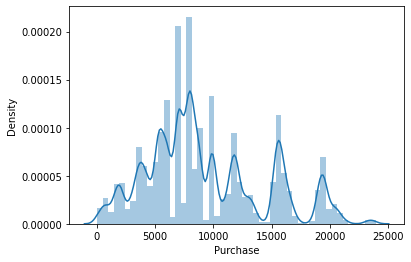

In [309]:
sns.distplot(train.loc[:, "Purchase"])

In [310]:
product_purchase = train.groupby(["Product_ID"]).Purchase.agg("mean").to_frame("mean_purchase_value").reset_index()
product_purchase.sort_values("mean_purchase_value", ascending = False)

,Product_ID,mean_purchase_value
836,P00086242,21256.505495
827,P00085342,20980.268116
1902,P00200642,20468.773234
1070,P00116142,20463.791277
1102,P00119342,20448.756494
...,...,...
3567,P00372445,374.930705
3568,P00375436,374.266585
3566,P00371644,362.911012
3565,P00370853,37.393643


In [311]:
product_purchase_count = train.groupby(["Product_ID"]).Purchase.agg("count").to_frame("count_of_purchase").reset_index()
product_purchase_count.sort_values("count_of_purchase", ascending = False)

,Product_ID,count_of_purchase
2536,P00265242,1880
249,P00025442,1615
1016,P00110742,1612
1030,P00112142,1562
565,P00057642,1470
...,...,...
669,P00068742,1
120,P00012342,1
1530,P00162742,1
891,P00091742,1


In [312]:
unique_products = pd.DataFrame(train.Product_ID.unique(), columns = ["Product_ID"])
unique_products

,Product_ID
0,P00069042
1,P00248942
2,P00087842
3,P00085442
4,P00285442
...,...
3626,P00375436
3627,P00372445
3628,P00370293
3629,P00371644


# Hypothesis

<AxesSubplot:title={'center':'City Category'}>

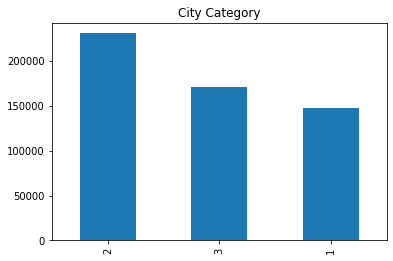

In [313]:
train["City_Category"].value_counts().plot(kind='bar',title="City Category")

City B have more purchase when compared to other citites


<AxesSubplot:title={'center':'Stay of Residence'}, ylabel='Stay_In_Current_City_Years'>

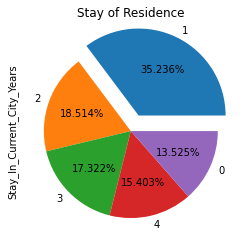

In [314]:
train["Stay_In_Current_City_Years"].value_counts().plot.pie(title="Stay of Residence", explode=(0.2,0,0,0,0),autopct="%1.3f%%")

C:\Users\Ajay_Thangavelu\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Age', ylabel='count'>

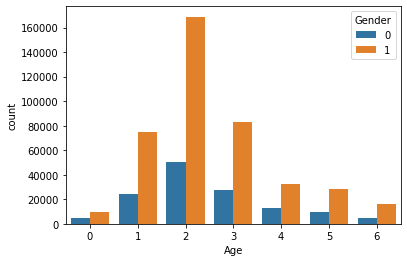

In [315]:
sns.countplot(train["Age"], hue=train["Gender"])

# Age Vs Purchase

<AxesSubplot:title={'center':'Age vs Purchase'}, xlabel='Age'>

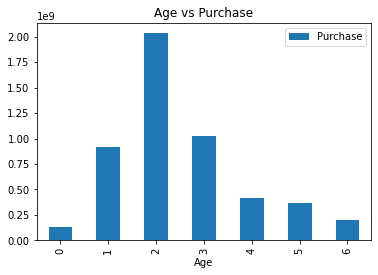

In [316]:
train.groupby(['Age']).sum()[["Purchase"]].plot(kind='bar', title='Age vs Purchase')

## Model Fitting

In [317]:
model = LinearRegression()
X = train.drop(columns=["User_ID", "Product_ID","Purchase"])
y = train["Purchase"].astype(int)

test_ = test.drop(columns=["User_ID",'Product_ID'])


In [343]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state=2)

In [344]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [357]:
linear = LinearRegression()
linear_analysis = model_analysis(linear, train_x, train_y, test_x)

MAE:  3525.213410097907
MSE:  21347953.496083185
RMSE:  4620.384561493035
R-Squared:  0.15290568459766862


In [361]:
pred_test = predict_test(linear, test_)

In [351]:
submission = pd.read_csv("../submission/sample_submission.csv")

In [352]:
submission["Purchase"] = pred_test
submission[["User_ID","Product_ID"]] = test[["User_ID","Product_ID"]]

In [353]:
pd.DataFrame(submission, columns=["Purchase","User_ID","Product_ID"]).to_csv(
    "../submission/sample_submission.csv", index=False)

# *******************************************************************************

In [355]:
def model_analysis(algorithm, train_x, train_y, test_x):
    algorithm.fit(train_x,train_y)
    pred_train = algorithm.predict(train_x)
    pred_test = algorithm.predict(test_x)
    pred_test = abs(pred_test)
    print("MAE: ",mean_absolute_error(train_y,pred_train))
    print("MSE: ",mean_squared_error(train_y,pred_train))
    print("RMSE: ",np.sqrt(mean_squared_error(train_y,pred_train)))
    print("R-Squared: ",r2_score(train_y,pred_train))

## Lasso CV

In [358]:
lasso_cv = LassoCV(cv=5)
lasso_analysis = model_analysis(lasso_cv, train_x, train_y, test_x)

MAE:  3524.4876632179294
MSE:  21353239.642284237
RMSE:  4620.9565722136185
R-Squared:  0.15269592845415247


In [360]:
def predict_test(algorithm, test):
    pred_test = linear.predict(test_)
    return pred_test